In [4]:
#Python Default 

import pickle

#Essentials

import time
import numpy as np

#from objproxies import *

import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

#Qiskit
    
## Qiskit Nature
    
from qiskit_nature.units import *   #ANGSTROM

from qiskit_nature.second_q.drivers import *    #PySCFDriver

from qiskit_nature.second_q.mappers import * #JordanWignerMapper

from qiskit_nature.second_q.algorithms import GroundStateEigensolver

from qiskit_nature.second_q.problems import ElectronicStructureProblem

from qiskit_nature.second_q.circuit.library import *  #Ansatz, HF

## Qiskit Algorithms
    
from qiskit_algorithms.minimum_eigensolvers import *    #VQE
 
from qiskit_algorithms.optimizers import *    #SLSQP

from qiskit.circuit.library import EfficientSU2   #EfficientSU2

## Qiskit Primitives

from qiskit.primitives import Estimator as Estimator_Nature

from qiskit_aer.primitives.estimator import Estimator as Estimator_Aer

## Qiskit Noise Models

from qiskit_aer.noise import NoiseModel

from qiskit.providers.fake_provider import *

##Qiskit Runtime IBM

from qiskit_ibm_runtime import QiskitRuntimeService

%matplotlib widget


# Definindo Funções

In [5]:
class Error_Qiskit:
    
    pass

class GroundState_H2:
    
    class Driver :
        
        def __init__(self, a, base, driver, charge, spin, unit):
            
            self._drivers = driver(
                atom= f"H 0 0 0; H 0 0 {a}",
                basis=base,
                charge=charge,
                spin=spin,
                unit=unit,
            )

        def run_driver(self) -> ElectronicStructureProblem:
            
            return self._drivers.run()
    
    def __init__(self, base = 'sto3g', unit = DistanceUnit.ANGSTROM, driver = PySCFDriver, charge = 0, spin = 0):
        
        self._problem = None
        self._dist = None
        self._base = base
        self._unit = unit
        self._driver = driver
        self._charge = charge
        self._spin = spin
        self._mapper = None
    
    def mapper(self):
        
        return self._mapper
    
    def problem (self, a = None) -> ElectronicStructureProblem:
        
        dist = self._dist if self._dist != None else a
        
        return self.Driver(dist, self._base, self._driver, self._charge, self._spin, self._unit).run_driver()
        
    def groundstate(self, a, mapper = JordanWignerMapper(), solver = NumPyMinimumEigensolver) -> float:
        
        self._mapper = mapper
        self._dist = a
        self._problem = self.problem(a)

        return np.array([a, (result := GroundStateEigensolver(mapper, (solver() if solver == NumPyMinimumEigensolver else solver)).solve(self._problem)).groundenergy + result.nuclear_repulsion_energy])
    
    def groundstate_curve(self, a, mapper = JordanWignerMapper(), solver = NumPyMinimumEigensolver) -> iter:
        
        for dist in a:

            yield self.groundstate(dist, mapper, solver)
    
class Solver(GroundState_H2):
    
    def __init__(self, estimator = Estimator_Nature, ansatz = UCCSD, optimizer = SLSQP):
        
        self.num_spatial_orbitals = 2
        self.num_particles = (1,1)
        self._mapper = JordanWignerMapper()
        self._estimator, self.estimator = estimator(), estimator
        self._optimizer, self.optimizer = optimizer(), optimizer
        self._ansatz, self.ansatz = ansatz(), ansatz
    
    def Ansatz(self):
    
        self._ansatz = self.ansatz(
            self.num_spatial_orbitals,
            self.num_particles,
            self._mapper,
            initial_state=HartreeFock(
            self.num_spatial_orbitals,
            self.num_particles,
            self._mapper)
            )
        
        return self
        
    def Estimator(self, shots = None, seed = 1, noise = None, session = None):
        
        if self.estimator == Estimator_Nature:
            
            self._estimator = self.estimator(options = {'shots': shots, 'seed': None})
        
        else:
            
            if shots == None:
                
                self._estimator = self.estimator(run_options = {"shots": None}, approximation=True)
        
            elif noise != None:
            
                self._estimator = self.estimator(backend_options = {"coupling_map": noise().coupling_map, "noise_model": NoiseModel.from_backend(noise())}, run_options = {"shots": shots, 'seed': seed}, transpile_options = {"seed_transpiler": seed})
            
            else:
                
                self._estimator = self.estimator(run_options = {"shots": shots, 'seed': seed}, transpile_options = {"seed_transpiler": seed})
                                
        return self
    
        
    def teste_Estimator(self, shots = None, seed = None, noise = None, session = None):
        
        estimators = {'Estimator_Nature' : 'options', 'Estimator_Aer' : 'run_options'}
        
        options = ''

        if self.estimator == Estimator_Nature:
            
            options_ = f'{{"shots": {shots}, "seed": {seed}}}'
        
            if noise != None:
                
                options_ += f'"coupling_map": {noise}().coupling_map, "noise_model": NoiseModel.from_backend({noise}())'
                
            options += f'options = {options_}'
                            
        else:
            
            options_ = [f'run_options = {{"shots": {shots}, "seed": {seed}}}']
                        
            if shots == None:
                
                options_.append('approximation = True')
            
            if session != None:
                
                options_.append(f'session = {session}')
            
            if seed != None:
                
                options_.append(f'transpile_options = {{"seed_transpiler": {seed}}}')

            if noise != None:
                
                options_.append(f'backend_options = {{"coupling_map": {noise}().coupling_map, "noise_model": NoiseModel.from_backend({noise}())}}')
            
            for a in options_:
                
                options += a + ','
            
            options = options[:-1]
        
        self._estimator = eval(f'self.estimator({options})')
        
        return self
    
    def Vqe(self):
    
        return VQE(self._estimator, self._ansatz, self._optimizer)
    

In [6]:
def salvar(a):
    with open(f'GroundState3/dados/{a}.pickle', 'wb') as f:
        pickle.dump(eval(a), f) 

def abrir(a):
    with open(f'GroundState3/dados/{a}.pickle', 'rb') as f:
        return pickle.load(f)

In [7]:
def Aer_Estimator(intervalo, base = "sto3g", optimizer = SLSQP(), session = None, noise = None, mapper = JordanWignerMapper(), shots = 2048, seed = None, method = "automatic"):
    
    for a in intervalo: 
        
        driver = PySCFDriver(
            atom= f"H 0 0 0; H 0 0 {a}",
            basis=base,
            charge=0,
            spin=0,
            unit=DistanceUnit.ANGSTROM,
        )
        
        es_problem = driver.run()

        options = ''

        options_ = [f'run_options = {{"shots": {shots}, "seed": {seed}}}']
                    
        if shots == None:
            
            options_.append('approximation = True')
        
        if session != None:
            
            options_.append(f'session = {session}')
        
        if seed != None:
            
            options_.append(f'transpile_options = {{"seed_transpiler": {seed}}}')

        if noise != None:
            
            options_.append(f'backend_options = {{"coupling_map": {noise}().coupling_map, "noise_model": NoiseModel.from_backend({noise}())}}')
        
        for b in options_:
            
            options += b + ','
        
        options = options[:-1]

        estimator = eval(f'Estimator_Aer({options})')
        
        mapper = mapper
        
        ansatz = UCCSD(
            es_problem.num_spatial_orbitals,
            es_problem.num_particles,
            mapper,
            initial_state=HartreeFock(
                es_problem.num_spatial_orbitals,
                es_problem.num_particles,
                mapper,
            ),
        )

        vqe_solver = VQE(estimator, ansatz, optimizer)
        vqe_solver.initial_point = [0.0] * ansatz.num_parameters
        
        calc = GroundStateEigensolver(mapper, vqe_solver)
        
        res = calc.solve(es_problem)
        
        yield [a, res.groundenergy + res.nuclear_repulsion_energy]

# Teste no IBM

In [8]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Session
from qiskit_ibm_runtime import Estimator as Estimator_Qiskit

service = QiskitRuntimeService(channel="ibm_quantum")

backend = service.backend("ibmq_qasm_simulator")

session = Session(backend=backend)

In [8]:
def Estimator_ibm (a, base = "sto3g", optimizer = SLSQP(), session = None, mapper = JordanWignerMapper(), shots = 2048, estimator = False):
           
    driver = PySCFDriver(
        atom= f"H 0 0 0; H 0 0 {a}",
        basis=base,
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )
    
    es_problem = driver.run()
    
    estimator = Estimator_Qiskit(session = session, options = {'shots': shots})
    
    mapper = mapper
    
    ansatz = UCCSD(
        es_problem.num_spatial_orbitals,
        es_problem.num_particles,
        mapper,
        initial_state=HartreeFock(
            es_problem.num_spatial_orbitals,
            es_problem.num_particles,
            mapper,
        ),
    )

    vqe_solver = VQE(estimator, ansatz, optimizer)
    vqe_solver.initial_point = [0.0] * ansatz.num_parameters
    
    calc = GroundStateEigensolver(mapper, vqe_solver)
    
    res = calc.solve(es_problem)
    
    return [a, res.groundenergy + res.nuclear_repulsion_energy] if estimator == False else estimator

def Estimator_intervalo(intervalo, base = "sto3g", optimizer = SLSQP(), session = None, mapper = JordanWignerMapper(), shots = 2048, seed = 1):
    
    for a in intervalo: 
        
        driver = PySCFDriver(
            atom= f"H 0 0 0; H 0 0 {a}",
            basis=base,
            charge=0,
            spin=0,
            unit=DistanceUnit.ANGSTROM,
        )
        
        es_problem = driver.run()
        
        estimator = Estimator_Qiskit(session = session, options = {'shots': shots})
        
        mapper = mapper
        
        ansatz = UCCSD(
            es_problem.num_spatial_orbitals,
            es_problem.num_particles,
            mapper,
            initial_state=HartreeFock(
                es_problem.num_spatial_orbitals,
                es_problem.num_particles,
                mapper,
            ),
        )

        vqe_solver = VQE(estimator, ansatz, optimizer)
        vqe_solver.initial_point = [0.0] * ansatz.num_parameters
        
        calc = GroundStateEigensolver(mapper, vqe_solver)
        
        res = calc.solve(es_problem)
        
        yield [a, res.groundenergy + res.nuclear_repulsion_energy]
        
def Estimator_ibm_draw (a, base = "sto3g", optimizer = SLSQP(), session = None, mapper = JordanWignerMapper(), shots = 2048, estimator = False):
           
    driver = PySCFDriver(
        atom= f"H 0 0 0; H 0 0 {a}",
        basis=base,
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )
    
    es_problem = driver.run()
    
    estimator = Estimator_Qiskit(session = session, options = {'shots': shots})
    
    mapper = mapper
    
    ansatz = SLSQP(
        es_problem.num_spatial_orbitals,
        es_problem.num_particles,
        mapper,
        initial_state=HartreeFock(
            es_problem.num_spatial_orbitals,
            es_problem.num_particles,
            mapper,
        ),
    )

    ansatz.num_parameters

In [20]:
intervalo_total = np.concatenate(((intervalo := np.concatenate(((intervalo_importante := np.linspace(0.1, (end := 1.5), 15)), np.linspace(end, 3, 10)))), (intervalo_distante := np.linspace(20, 30, 10))))

for a in (metodos := range(61, 100, 10)):
    
   exec(f"estimator_qiskit_shots_{a} = np.array(list(Estimator_intervalo(intervalo, shots = {a}, session=session, seed = 1)))")
   exec(f'estimator_qiskit_shots_{a}[:, 1] -= (error := - np.polyfit(intervalo_distante, np.array(list(Estimator_intervalo(intervalo_distante, shots = {a}, session=session, seed = 1)))[:,1], 0))')
   
   exec(f"estimator_qiskit_essencial_{a} = np.array(list(Estimator_intervalo(np.linspace((minimo := min(estimator_qiskit_shots_{a}, key = lambda x: x[1])[0]) + (erro := minimo * 10/100), minimo - erro, 10), shots = {a}, session=session, seed = 1)))")
   exec(f"estimator_qiskit_essencial_{a}[:, 1] -= error")
   
   exec(f"estimator_qiskit_shots_total_{a} = np.concatenate((estimator_qiskit_shots_{a}, estimator_qiskit_essencial_{a}))")
   exec(f"estimator_qiskit_shots_total_{a} = estimator_qiskit_shots_total_{a}[np.argsort(estimator_qiskit_shots_total_{a}[:, 0])]")
   
   salvar(f'estimator_qiskit_shots_{a}')
   salvar(f'estimator_qiskit_shots_total_{a}')
   salvar(f'estimator_qiskit_essencial_{a}')

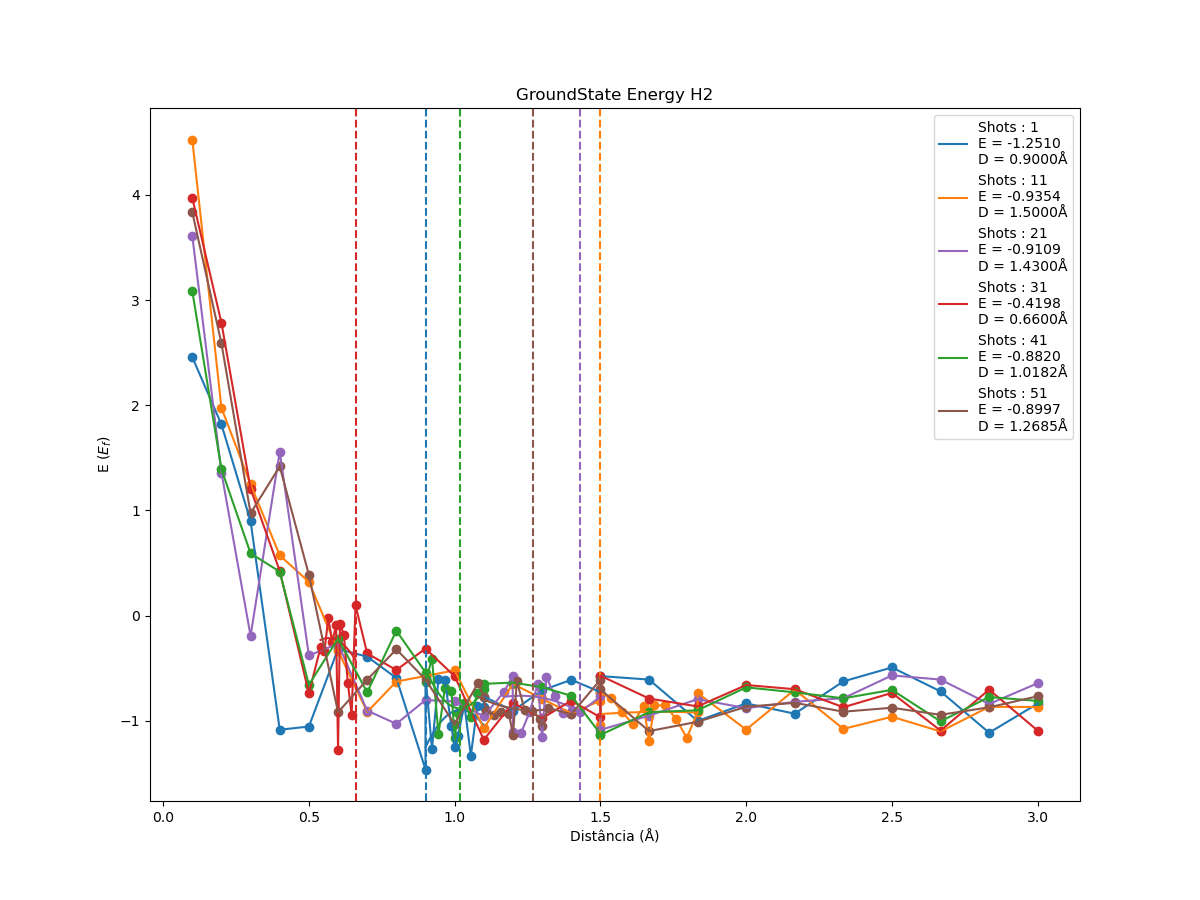

In [10]:
for a in (metodos := range(1, 100, 10)):
    
    try:
        exec(f"estimator_qiskit_shots_{a} = abrir(f'estimator_qiskit_shots_{a}')")
        exec(f"estimator_qiskit_shots_total_{a} = abrir(f'estimator_qiskit_shots_total_{a}')")
        exec(f"estimator_qiskit_essencial_{a} = abrir(f'estimator_qiskit_essencial_{a}')")

    except: pass

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot()


for a,b in zip(metodos, ['tab:blue', 'tab:orange', 'tab:purple', 'tab:red', 'tab:green', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'lime']):

    try:    
        ax.plot((estimator_total := eval(f"estimator_qiskit_shots_total_{a}"))[:, 0], estimator_total[:, 1], color = b)
        ax.scatter((estimator_total := eval(f"estimator_qiskit_shots_total_{a}"))[:, 0], estimator_total[:, 1], color = b)
        ax.plot((x_importante := np.linspace(min((estimator_essencial := eval(f"estimator_qiskit_essencial_{a}"))[:, 0]), max(estimator_essencial[:, 0]), 500)), (y_importante := np.polyval(np.polyfit(estimator_essencial[:, 0], estimator_essencial[:, 1], 2), x_importante)), label=f'Shots : {a}\nE = {(min_y_importante := min(y_importante)):.4f}\nD = {x_importante[np.nonzero(y_importante == min_y_importante)[0][0]]:.4f}Å', color = b)
        
        ax.axvline(x=x_importante[np.argmin(y_importante)], linestyle='--', color=b)

    except: pass    

ax.set_xlabel('Distância (Å)')
ax.set_ylabel('E $(E_f)$')

ax.set_title('GroundState Energy H2')

ax.legend()

In [9]:
from qiskit.transpiler import PassManager
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime.transpiler.passes.scheduling import (
    ALAPScheduleAnalysis,
    PadDynamicalDecoupling,
)
from qiskit.circuit.library import XGate

In [12]:
def Estimator_ibm_real (a, base = "sto3g", optimizer = SLSQP(), session = None, mapper = JordanWignerMapper(), shots = 2048, estimator = False):
           
    driver = PySCFDriver(
        atom= f"H 0 0 0; H 0 0 {a}",
        basis=base,
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )
    
    es_problem = driver.run()
    
    estimator = Estimator_Qiskit(session = session, options = {'shots': shots})
    
    mapper = mapper
    
    ansatz = UCCSD(
        es_problem.num_spatial_orbitals,
        es_problem.num_particles,
        mapper,
        initial_state=HartreeFock(
            es_problem.num_spatial_orbitals,
            es_problem.num_particles,
            mapper,
        ),
    )

    target = backend.target
    pm = generate_preset_pass_manager(target=target, optimization_level=3)

    ansatz_ibm = pm.run(ansatz)
    
    #ansatz_ibm.draw(output="mpl", idle_wires=False, style="iqp")
    
    def callback_func(**kwargs):
        pass_ = kwargs['pass_']
        dag = kwargs['dag']
        time = kwargs['time']
        property_set = kwargs['property_set']
        count = kwargs['count']

In [10]:
service = QiskitRuntimeService(channel="ibm_quantum")

backend = service.least_busy(operational=True, simulator=False)

backend.name

'ibm_kyoto'

In [13]:
Estimator_ibm_real('1', session=session)